# Clustering: Data Labeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import swifter

from ast import literal_eval
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
indoset_lexicon_neg_path = '../dataset/wordlist/indoset_lexicon_neg.csv'
indoset_lexicon_pos_path = '../dataset/wordlist/indoset_lexicon_pos.csv'
vulgarity_lexicon_path = '../dataset/wordlist/vulgarity_lexicon.csv'

target = 'tweets.csv'
processed_target_path = f'../dataset/processed/processed_{target}'
output_path = f'../dataset/processed/supervised_{target}'

In [3]:
indoset_lexicon_neg = pd.read_csv(indoset_lexicon_neg_path, delimiter='\t')
indoset_lexicon_pos = pd.read_csv(indoset_lexicon_pos_path, delimiter='\t')
vulgarity_lexicon = pd.read_csv(vulgarity_lexicon_path, header=None, delimiter='\t')

print(f"Total lexicon neg:", len(indoset_lexicon_neg))
print(f"Total lexicon pos:", len(indoset_lexicon_pos))
print(f"Total lexicon vulgarity:", len(vulgarity_lexicon))

Total lexicon neg: 6609
Total lexicon pos: 3609
Total lexicon vulgarity: 62


In [4]:
lexicon_dict = pd.concat([indoset_lexicon_pos, indoset_lexicon_neg], ignore_index=True)

vulgarity_lexicon_weight = [-5 for word in vulgarity_lexicon[0]]
vulgarity_lexicon = pd.DataFrame(list(zip(vulgarity_lexicon[0],vulgarity_lexicon_weight)),columns =['word','weight'])


lexicon_dict = pd.concat([lexicon_dict, vulgarity_lexicon], ignore_index=True)
print(len(lexicon_dict))
lexicon_dict.sample(5)

10280


,word,weight
4596,mengejek,-4
1144,penanganan,1
1406,cocok,4
1036,berkarya,3
745,rasio,1
8864,bergosok,-3
8851,himpunan,-4


Total negative lexicon: 6671
Total positive lexicon: 3609


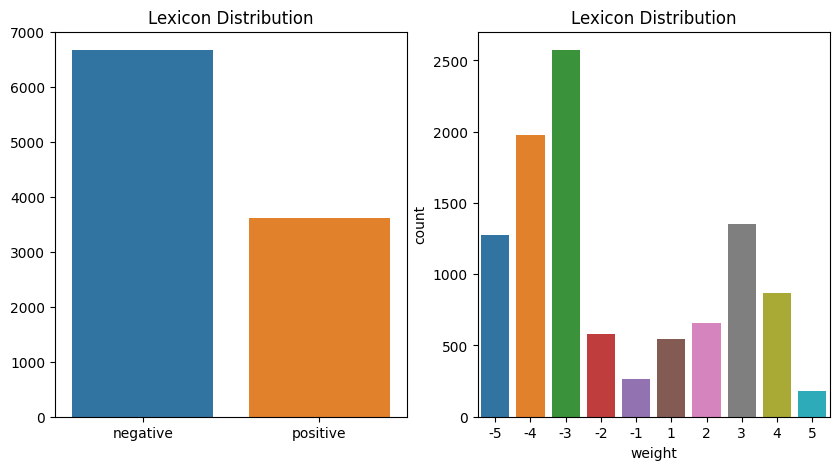

In [5]:
# count how many negative words in lexicon_dict
neg_lexicon = lexicon_dict[lexicon_dict['weight'] < 0]
pos_lexicon = lexicon_dict[lexicon_dict['weight'] > 0]
print(f"Total negative lexicon:", len(neg_lexicon))
print(f"Total positive lexicon:", len(pos_lexicon))

plt.figure(figsize=(10,5))
# make bar plot from negative and positive lexicon
plt.subplot(1,2,1)
sns.barplot(x=['negative','positive'], y=[len(neg_lexicon), len(pos_lexicon)])
plt.title('Lexicon Distribution')
# visualize the amount of negative and positive words based on weight in lexicon_dict
plt.subplot(1,2,2)
sns.countplot(x='weight', data=lexicon_dict)
plt.title('Lexicon Distribution')
plt.show()

In [6]:
def case_folding(text):
    return text.lower()
    
def num_of_words(item):
    words = word_tokenize(item['word'])
    number = len(words)
    return number

In [7]:
lexicon_dict['word'] = lexicon_dict['word'].swifter.apply(case_folding)
lexicon_dict['num_of_words'] = lexicon_dict.swifter.apply(num_of_words, axis=1)
lexicon_dict = lexicon_dict.drop(lexicon_dict[lexicon_dict['num_of_words'] == 0].index, axis=0)
lexicon_dict.drop_duplicates(subset=['word'], keep='first',inplace=True)
lexicon_dict = lexicon_dict.reset_index(drop=True)

print(len(lexicon_dict))
lexicon_dict.sample(5)

Pandas Apply:   0%|          | 0/10280 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10280 [00:00<?, ?it/s]

9109


,word,weight,num_of_words
3974,berat pinggul,-2,2
2076,kaji,4,1
6442,melanggar,-5,1
3062,tempoh,3,1
166,mengantisipasi,3,1


In [8]:
lexicon_dict.to_csv('../dataset/wordlist/lexicon_dict_all.csv', index=False)

lexicon_dict[lexicon_dict['num_of_words'] == 3].sample(5)

,word,weight,num_of_words
3607,putus tali gantung,-2,3
1925,jalan bebas hambat,2,3
7468,buang air kecil,-3,3
3643,menarik napas penghabisan,-5,3
1902,minta kpd tuhan,3,3
1851,naik ke pelamin,3,3


In [9]:
lexicon = dict(zip(lexicon_dict['word'], lexicon_dict['weight']))
vectorizer = CountVectorizer(vocabulary=lexicon.keys(), ngram_range=(1, 5))

def detokenize(tokens):
	return TreebankWordDetokenizer().detokenize(tokens)

def determine_polarity(text):
	bow_matrix = vectorizer.fit_transform([text]).toarray()
	
	polarity = 0
	for word, score in zip(vectorizer.get_feature_names_out(), bow_matrix[0]):
		polarity += lexicon[word] * score
	return polarity

def sentiment_analyze(polarity):
	return 1 if polarity >= 0 else 0

In [10]:
df = pd.read_csv(processed_target_path, delimiter=';')

df['tokens_ready'] = df['tokens_ready'].swifter.apply(literal_eval)
df['text'] = df['tokens_ready'].swifter.apply(detokenize)
df['polarity'] = df['text'].swifter.apply(determine_polarity)
df['sentiment'] = df['polarity'].swifter.apply(sentiment_analyze)

df.to_csv(output_path, index=False, header=True, sep=';')

df[['content', 'tokens_ready', 'text', 'polarity', 'sentiment']].head()

Pandas Apply:   0%|          | 0/7080 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7080 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7080 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7080 [00:00<?, ?it/s]

,content,tokens_ready,text,polarity,sentiment
0,@soeyoto1 @msaid_didu Bukti kalau Pemerintahan...,"[bukti, perintah, pro, rakyat, pro, oligarki, ...",bukti perintah pro rakyat pro oligarki bbmnya ...,-2,0
1,"@KompasTV Mentri esdm, trus patokanmu apa? Kan...","[menteri, esdm, patok, kantong, jebol, korupsi...",menteri esdm patok kantong jebol korupsi imbas...,-9,0
2,@hnurwahid Ngaku masih subsidi tapi ada swasta...,"[subsidi, swasta, jual, murah, subsidi, pimpin...",subsidi swasta jual murah subsidi pimpin tukan...,6,1
3,@Tan_Mar3M Kalau Vivo bisaberani bertahan deng...,"[berani, tahan, harga, nasib]",berani tahan harga nasib,4,1
4,Menteri BUMN Erick Thohir menegaskan persiapan...,"[menteri, bumn, erick, thohir, indonesia, tran...",menteri bumn erick thohir indonesia transisi e...,2,1


1    4789
0    2315
Name: sentiment, dtype: int64


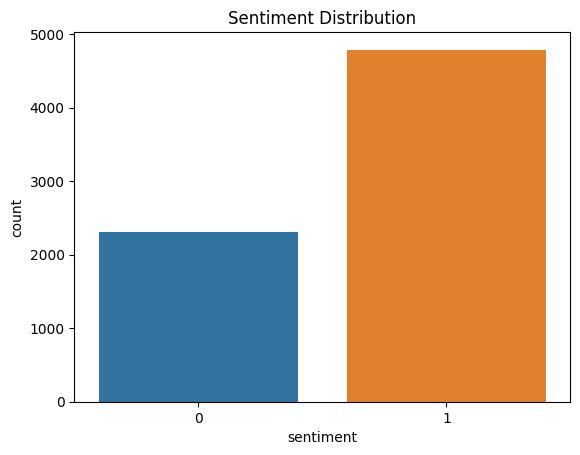

In [11]:
print(df['sentiment'].value_counts())

# make bar plot from negative and positive lexicon
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

1    4789
0    4789
Name: sentiment, dtype: int64


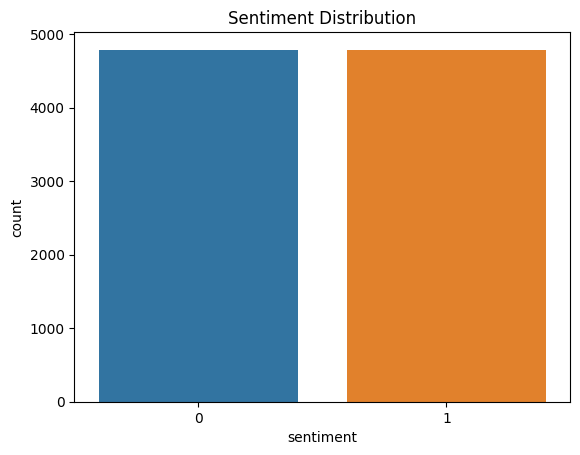

In [12]:
from sklearn.utils import resample

df_majority = df[df.sentiment==1]
df_minority = df[df.sentiment==0]

df_minority_upsampled = resample(df_minority,
                                    replace=True,
                                    n_samples=len(df_majority),
                                    random_state=123)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.to_csv('../dataset/processed/supervised_tweets_upsampled.csv', index=False, header=True, sep=';')

print(df_upsampled['sentiment'].value_counts())

# make bar plot from negative and positive lexicon
sns.countplot(x='sentiment', data=df_upsampled)
plt.title('Sentiment Distribution')
plt.show()